In [1]:
import torch 
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import os
import random
from PIL import Image
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
class MNISTpairs(data.Dataset):
    """
    Load the MNIST dataset in pairs of similar(positive)/non-similar(negative) pairs
    """

    def __init__(self, mnist_dataset):    
        self.mnist_dataset = mnist_dataset
        self.transform = self.mnist_dataset.transform
        self.labels = self.mnist_dataset.train_labels
        self.data = self.mnist_dataset.train_data                
        # indices of images for each class
        self.class_idx = [np.where(self.labels==x)[0] for x in range(0,10)]
    
    def __getitem__(self, index):
        
        # anchor image
        img1, label1 = self.data[index], self.labels[index].item()
        # draw another positive (1) or negative (0) image
        pair_label = np.random.randint(0, 2)
        
        if pair_label == 1:
            # choose an image with the same label as the anchor - avoid itself
            index2 = index
            while index2 == index:
                index2 = np.random.choice(self.class_idx[label1])
            img2 = self.data[index2]
        else:
            # choose an image with the different label than the anchor 
            img2 = self.data[np.random.choice(self.class_idx[ np.random.choice(np.setdiff1d(range(0,10), label1))])]
            
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return (img1, img2), pair_label
    
    def __len__(self):
        return len(self.data)
        
    
# mnist dataset structure - test part
mnist_dataset_test = datasets.MNIST('vs3ex1data/mnist_data', train=False, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ]))
    
# mnist dataset structure - train part
mnist_dataset_train = datasets.MNIST('vs3ex1data/mnist_data', train=True, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ]))
            
# mnist dataset in positive/negative pairs structure 
mnist_dataset_train_pairs = MNISTpairs(mnist_dataset_train)

/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [3]:
def l2n(x, eps=1e-6):
    """
    Vector L2 normalization 
    """
    return x / (torch.norm(x, p=2, dim=1, keepdim=True) + eps).expand_as(x)

class MnistNetEmb(nn.Module):
    """
    Liteweight network architecture for the Mnist dataset (digit) to extract descriptors/embeddings
    """

    def __init__(self):
        super(MnistNetEmb, self).__init__()

        # fully convolutional part
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, 4, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True)            
        )
        
        # embedding network, FC layers
        self.embedder = nn.Sequential(
            nn.Linear(16*4,16)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.embedder(x.view(-1,x.size(-3)*x.size(-2)*x.size(-1)))
        return l2n(x)
    

In [6]:
def train2(model, train_loader, optimizer, margin = 0.9):
    """
    Training of an epoch with Contrastive loss and training pairs
    model: network
    train_loader: train_loader loading pairs of positive/negative images and pair-label in batches. 
    optimizer: optimizer to use in the training
    margin: loss margin
    """

    model.train()
    all_neg_dist = torch.Tensor()
    all_pos_dist = torch.Tensor()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # extract descriptor for anchor and the corresponding pos/neg images
        v1, v2 = model(data[0]), model(data[1])
        
        # compute the contrastive loss
        distances = (v2 - v1).pow(2).sum(1).sqrt()        
        loss = 0.5 * (target.float() * distances.pow(2) + (1-target).float()*F.relu(margin - distances).pow(2))
        
        loss.sum().backward()
        optimizer.step()

        all_neg_dist = torch.cat((all_neg_dist, distances[torch.nonzero(1-target)].view(-1))) # for statistics
        all_pos_dist = torch.cat((all_pos_dist, distances[torch.nonzero(target)].view(-1))) # for statistics
        total_loss = total_loss + loss.sum().data.numpy()
        
        if batch_idx % 100 == 0:
            print('[{}/{} ({:.0f}%)]\tBatch loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.mean()))
    print('Epoch average loss {:.6f}'.format(total_loss/len(train_loader.dataset)))

    plt.hist(all_pos_dist.data.numpy(), 20, alpha = 0.5, label = 'pos')
    plt.hist(all_neg_dist.data.numpy(), 20, alpha = 0.5, label = 'neg')
    plt.title('Distribution of distances for positive and negative pairs')
    plt.legend(loc='upper right')
    plt.show()

    
def test(model, test_loader, step = 100):
    """
    Compute accuracy on the test set
    model: network
    test_loader: test_loader loading images and labels in batches
    step: step to iterate over images (for faster evaluation)
    """

    model.eval()
    des = torch.Tensor()
    labels = torch.LongTensor()
    for batch_idx, (data, target) in enumerate(test_loader):
        des = torch.cat((des, model(data)))
        labels = torch.cat((labels, target))
    
    # compute all pair-wise distances
    cdistances = cdist(des.data.numpy(), des.data.numpy(), 'euclidean')
        
    # find rank of closest positive image (using each descriptor as a query)
    minrank_positive = []
    for i in range(0, len(cdistances), step):
        idx = np.argsort(cdistances[i])
        minrank_positive.append( np.min([j for (j,x) in enumerate(labels[idx[1:-1]]) if x==labels[i]]) )
    
    print('Validation: At-least-1-pos@1 {:.3f}'.format((np.array(minrank_positive) <1).mean()))
    print('Validation: At-least-1-pos@3 {:.3f}'.format((np.array(minrank_positive) <3).mean()))


In [7]:
# loader of the training set in pairs
train_loader_pairs = torch.utils.data.DataLoader(mnist_dataset_train_pairs, batch_size=64, shuffle=True)
#loader of the test set (no pairs here)
test_loader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=512, shuffle=False)

model = MnistNetEmb() # initialize the network

print('Validating the randomly initialized network')
test(model, test_loader) # test the randomly initialized network


Validating the randomly initialized network
Validation: At-least-1-pos@1 0.760
Validation: At-least-1-pos@3 0.890


Training with Contrastive loss and training pairs
Epoch 1
[0/60000 (0%)]	Batch loss: 0.069083


/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)


[200/60000 (11%)]	Batch loss: 0.051333
[400/60000 (21%)]	Batch loss: 0.050721
[600/60000 (32%)]	Batch loss: 0.059819
[800/60000 (43%)]	Batch loss: 0.045930
[1000/60000 (53%)]	Batch loss: 0.043200
[1200/60000 (64%)]	Batch loss: 0.046456
[1400/60000 (75%)]	Batch loss: 0.041004
[1600/60000 (85%)]	Batch loss: 0.041783
[1800/60000 (96%)]	Batch loss: 0.038050
Epoch average loss 0.047053


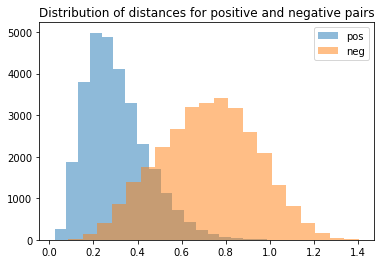

Validation: At-least-1-pos@1 0.900
Validation: At-least-1-pos@3 0.970
Epoch 2
[0/60000 (0%)]	Batch loss: 0.024979
[200/60000 (11%)]	Batch loss: 0.037804
[400/60000 (21%)]	Batch loss: 0.029939
[600/60000 (32%)]	Batch loss: 0.030726
[800/60000 (43%)]	Batch loss: 0.034484
[1000/60000 (53%)]	Batch loss: 0.043889
[1200/60000 (64%)]	Batch loss: 0.031466
[1400/60000 (75%)]	Batch loss: 0.045320
[1600/60000 (85%)]	Batch loss: 0.044112
[1800/60000 (96%)]	Batch loss: 0.036645
Epoch average loss 0.035491


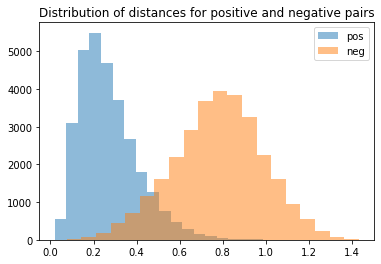

Validation: At-least-1-pos@1 0.910
Validation: At-least-1-pos@3 0.970
Epoch 3
[0/60000 (0%)]	Batch loss: 0.034640
[200/60000 (11%)]	Batch loss: 0.028943
[400/60000 (21%)]	Batch loss: 0.035043
[600/60000 (32%)]	Batch loss: 0.036852
[800/60000 (43%)]	Batch loss: 0.034445
[1000/60000 (53%)]	Batch loss: 0.036482
[1200/60000 (64%)]	Batch loss: 0.021911
[1400/60000 (75%)]	Batch loss: 0.030632
[1600/60000 (85%)]	Batch loss: 0.035585
[1800/60000 (96%)]	Batch loss: 0.030663
Epoch average loss 0.033299


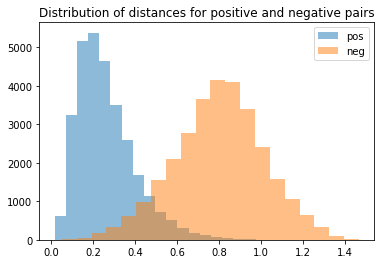

Validation: At-least-1-pos@1 0.910
Validation: At-least-1-pos@3 0.960
Epoch 4
[0/60000 (0%)]	Batch loss: 0.030353
[200/60000 (11%)]	Batch loss: 0.023969
[400/60000 (21%)]	Batch loss: 0.044331
[600/60000 (32%)]	Batch loss: 0.027357
[800/60000 (43%)]	Batch loss: 0.036219
[1000/60000 (53%)]	Batch loss: 0.025824
[1200/60000 (64%)]	Batch loss: 0.028671
[1400/60000 (75%)]	Batch loss: 0.023121
[1600/60000 (85%)]	Batch loss: 0.026969
[1800/60000 (96%)]	Batch loss: 0.025550
Epoch average loss 0.032300


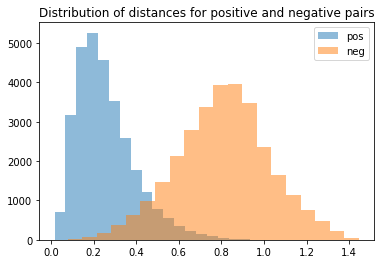

Validation: At-least-1-pos@1 0.920
Validation: At-least-1-pos@3 0.960
Epoch 5
[0/60000 (0%)]	Batch loss: 0.033524
[200/60000 (11%)]	Batch loss: 0.029006
[400/60000 (21%)]	Batch loss: 0.041951
[600/60000 (32%)]	Batch loss: 0.028838
[800/60000 (43%)]	Batch loss: 0.038630
[1000/60000 (53%)]	Batch loss: 0.037955
[1200/60000 (64%)]	Batch loss: 0.023331
[1400/60000 (75%)]	Batch loss: 0.037095
[1600/60000 (85%)]	Batch loss: 0.037075
[1800/60000 (96%)]	Batch loss: 0.021852
Epoch average loss 0.031676


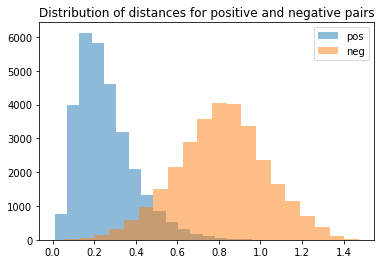

Validation: At-least-1-pos@1 0.930
Validation: At-least-1-pos@3 0.960
Epoch 6
[0/60000 (0%)]	Batch loss: 0.026367
[200/60000 (11%)]	Batch loss: 0.042991
[400/60000 (21%)]	Batch loss: 0.031670
[600/60000 (32%)]	Batch loss: 0.025616
[800/60000 (43%)]	Batch loss: 0.032820
[1000/60000 (53%)]	Batch loss: 0.021673
[1200/60000 (64%)]	Batch loss: 0.032167
[1400/60000 (75%)]	Batch loss: 0.028798
[1600/60000 (85%)]	Batch loss: 0.032663
[1800/60000 (96%)]	Batch loss: 0.022075
Epoch average loss 0.030798


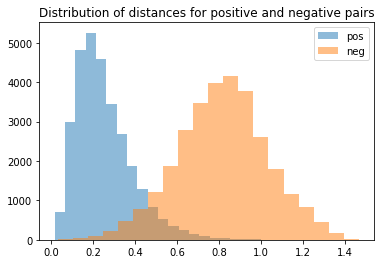

Validation: At-least-1-pos@1 0.950
Validation: At-least-1-pos@3 0.980
Epoch 7
[0/60000 (0%)]	Batch loss: 0.028994
[200/60000 (11%)]	Batch loss: 0.027365
[400/60000 (21%)]	Batch loss: 0.024419
[600/60000 (32%)]	Batch loss: 0.038928
[800/60000 (43%)]	Batch loss: 0.033464
[1000/60000 (53%)]	Batch loss: 0.025665
[1200/60000 (64%)]	Batch loss: 0.028846
[1400/60000 (75%)]	Batch loss: 0.023961
[1600/60000 (85%)]	Batch loss: 0.026803
[1800/60000 (96%)]	Batch loss: 0.037381
Epoch average loss 0.030405


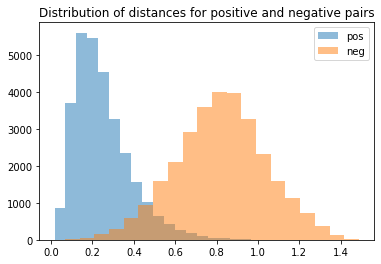

Validation: At-least-1-pos@1 0.950
Validation: At-least-1-pos@3 0.960
Epoch 8
[0/60000 (0%)]	Batch loss: 0.031655
[200/60000 (11%)]	Batch loss: 0.033606
[400/60000 (21%)]	Batch loss: 0.031908
[600/60000 (32%)]	Batch loss: 0.028374
[800/60000 (43%)]	Batch loss: 0.031862
[1000/60000 (53%)]	Batch loss: 0.028727
[1200/60000 (64%)]	Batch loss: 0.035694
[1400/60000 (75%)]	Batch loss: 0.038049
[1600/60000 (85%)]	Batch loss: 0.029052
[1800/60000 (96%)]	Batch loss: 0.025712
Epoch average loss 0.029709


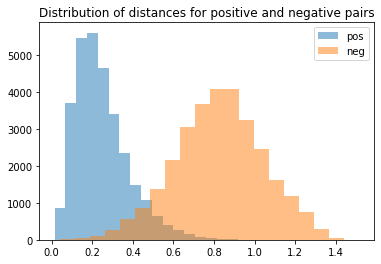

Validation: At-least-1-pos@1 0.920
Validation: At-least-1-pos@3 0.970
Epoch 9
[0/60000 (0%)]	Batch loss: 0.024900
[200/60000 (11%)]	Batch loss: 0.023256
[400/60000 (21%)]	Batch loss: 0.024296
[600/60000 (32%)]	Batch loss: 0.033326
[800/60000 (43%)]	Batch loss: 0.038416
[1000/60000 (53%)]	Batch loss: 0.023575
[1200/60000 (64%)]	Batch loss: 0.031271
[1400/60000 (75%)]	Batch loss: 0.031728
[1600/60000 (85%)]	Batch loss: 0.025741
[1800/60000 (96%)]	Batch loss: 0.025865
Epoch average loss 0.029662


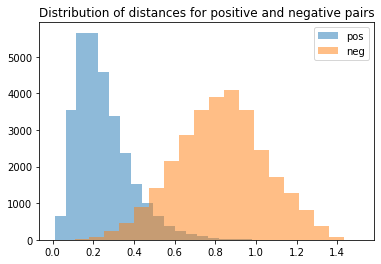

Validation: At-least-1-pos@1 0.940
Validation: At-least-1-pos@3 0.980
Epoch 10
[0/60000 (0%)]	Batch loss: 0.034058
[200/60000 (11%)]	Batch loss: 0.033783
[400/60000 (21%)]	Batch loss: 0.026401
[600/60000 (32%)]	Batch loss: 0.032245
[800/60000 (43%)]	Batch loss: 0.027170
[1000/60000 (53%)]	Batch loss: 0.031304
[1200/60000 (64%)]	Batch loss: 0.031123
[1400/60000 (75%)]	Batch loss: 0.018911
[1600/60000 (85%)]	Batch loss: 0.044169
[1800/60000 (96%)]	Batch loss: 0.030678
Epoch average loss 0.029152


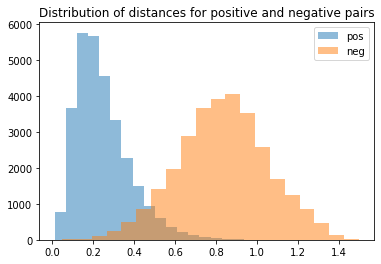

Validation: At-least-1-pos@1 0.950
Validation: At-least-1-pos@3 0.990


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print('Training with Contrastive loss and training pairs')
# train with contrastive loss
contrastive_margin = 0.9
torch.nonzero(pred, as_tuple=True) # to avoid UserWarning
for epoch in range(1, 10 + 1):
        print('Epoch {}'.format(epoch))
        train2(model, train_loader_pairs, optimizer, contrastive_margin)
        test(model, test_loader)

### Task 1:
In convolutional model we have all the layers set up, as there the convolution works, we take batches of some size and compare them with an example. The comparison is used to be done as the following: we take the feature of a particular size and compare them with the parts of the image. As we are doing this kind of thing, we simply feed the model with the test data, from which we take features and with which we compare all parts of the image over and over again. Then we get a map over the whole image where the feature occurs. \
Afterwards we get a stack of filtered images, that are filtered accoring to the features we have had.\
Then we can easily clear up the data with pooling and ReLU, so we can predict correct result even with not-trained model.

### Task 2:

In [36]:
class MNISTtriplets(data.Dataset):
    """
    Load the MNIST dataset in pairs of similar(positive)/non-similar(negative) pairs
    """

    def __init__(self, mnist_dataset):    
        self.mnist_dataset = mnist_dataset
        self.transform = self.mnist_dataset.transform
        self.labels = self.mnist_dataset.train_labels
        self.data = self.mnist_dataset.train_data                
        # indices of images for each class
        self.class_idx = [np.where(self.labels==x)[0] for x in range(0,10)]
    
    def __getitem__(self, index):
        # anchor image
        img1, label1 = self.data[index], self.labels[index].item()
        # draw another positive (1) and negative (0) images
        # choose an image with the same label as the anchor - avoid itself
        index2 = index
        while index2 == index:
            index2 = np.random.choice(self.class_idx[label1])
        img2 = self.data[index2]
        
        # choose an image with the different label than the anchor
        img3 = self.data[np.random.choice(self.class_idx[ np.random.choice(np.setdiff1d(range(0,10), label1))])]
            
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        
        # 1 - positive, 2 - negative
        return (img1, img2, img3), (1, 2)
    
    def __len__(self):
        return len(self.data)

            
# mnist dataset in positive/negative pairs structure 
mnist_dataset_train_triplets = MNISTtriplets(mnist_dataset_train)

/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [83]:
def train3(model, train_loader, optimizer, margin=1):
    """
    Training of an epoch with Contrastive loss and training pairs
    model: network
    train_loader: train_loader loading pairs of positive/negative images and pair-label in batches. 
    optimizer: optimizer to use in the training
    margin: loss margin
    """
    model.train()
    all_neg_dist = torch.Tensor()
    all_pos_dist = torch.Tensor()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # extract descriptor for anchor and the corresponding pos and neg images
        anchor, positive, negative = model(data[0]), model(data[1]), model(data[2])
        
        # compute the contrastive loss
        dis_p = (positive - anchor).pow(2).sum(1).sqrt()
        dis_n = (negative - anchor).pow(2).sum(1).sqrt()
        
        tr_loss = nn.TripletMarginLoss(margin=margin)
        loss = tr_loss(anchor, positive, negative)
        
        loss.backward()
        optimizer.step()

        all_neg_dist = torch.cat((all_neg_dist, dis_n.view(-1))) # for statistics
        all_pos_dist = torch.cat((all_pos_dist, dis_p.view(-1))) # for statistics
        
        total_loss = total_loss + loss.data.numpy()
        
        if batch_idx % 100 == 0:
            print('[{}/{} ({:.0f}%)]\tBatch loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.mean()))
    print('Epoch average loss {:.6f}'.format(total_loss/len(train_loader.dataset)))

    plt.hist(all_pos_dist.data.numpy(), 20, alpha = 0.5, label = 'pos')
    plt.hist(all_neg_dist.data.numpy(), 20, alpha = 0.5, label = 'neg')
    plt.title('Distribution of distances for positive and negative pairs')
    plt.legend(loc='upper right')
    plt.show()

    
def test(model, test_loader, step = 100):
    """
    Compute accuracy on the test set
    model: network
    test_loader: test_loader loading images and labels in batches
    step: step to iterate over images (for faster evaluation)
    """

    model.eval()
    des = torch.Tensor()
    labels = torch.LongTensor()
    for batch_idx, (data, target) in enumerate(test_loader):
        des = torch.cat((des, model(data)))
        labels = torch.cat((labels, target))
    
    # compute all pair-wise distances
    cdistances = cdist(des.data.numpy(), des.data.numpy(), 'euclidean')
        
    # find rank of closest positive image (using each descriptor as a query)
    minrank_positive = []
    for i in range(0, len(cdistances), step):
        idx = np.argsort(cdistances[i])
        minrank_positive.append( np.min([j for (j,x) in enumerate(labels[idx[1:-1]]) if x==labels[i]]) )
    
    print('Validation: At-least-1-pos@1 {:.3f}'.format((np.array(minrank_positive) <1).mean()))
    print('Validation: At-least-1-pos@3 {:.3f}'.format((np.array(minrank_positive) <3).mean()))


In [84]:
# loader of the training set in triples
train_loader_triplets = torch.utils.data.DataLoader(mnist_dataset_train_triplets, batch_size=63, shuffle=True)
#loader of the test set (no pairs here)
test_loader2 = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=504, shuffle=False)

model = MnistNetEmb() # initialize the network

print('Validating the randomly initialized network')
test(model, test_loader2) # test the randomly initialized network

Validating the randomly initialized network
Validation: At-least-1-pos@1 0.690
Validation: At-least-1-pos@3 0.860


Training with Contrastive loss and training triples
Epoch 1
[0/60000 (0%)]	Batch loss: 0.882750


/Users/sofiapetryshyn/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[300/60000 (10%)]	Batch loss: 0.474363
[600/60000 (21%)]	Batch loss: 0.431205
[900/60000 (31%)]	Batch loss: 0.459105
[1200/60000 (42%)]	Batch loss: 0.328325
[1500/60000 (52%)]	Batch loss: 0.453305
[1800/60000 (63%)]	Batch loss: 0.405638
[2100/60000 (73%)]	Batch loss: 0.318604
[2400/60000 (84%)]	Batch loss: 0.352993
[2700/60000 (94%)]	Batch loss: 0.328933
Epoch average loss 0.006571


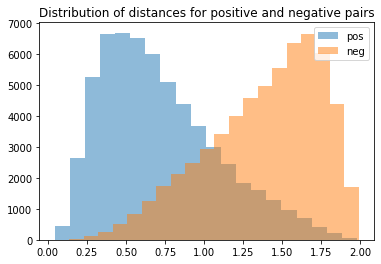

Validation: At-least-1-pos@1 0.920
Validation: At-least-1-pos@3 0.950
Epoch 2
[0/60000 (0%)]	Batch loss: 0.455050
[300/60000 (10%)]	Batch loss: 0.348503
[600/60000 (21%)]	Batch loss: 0.350347
[900/60000 (31%)]	Batch loss: 0.182103
[1200/60000 (42%)]	Batch loss: 0.258772
[1500/60000 (52%)]	Batch loss: 0.280388
[1800/60000 (63%)]	Batch loss: 0.330869
[2100/60000 (73%)]	Batch loss: 0.207719
[2400/60000 (84%)]	Batch loss: 0.312583
[2700/60000 (94%)]	Batch loss: 0.347588
Epoch average loss 0.004822


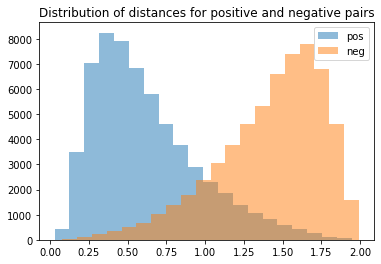

Validation: At-least-1-pos@1 0.840
Validation: At-least-1-pos@3 0.960
Epoch 3
[0/60000 (0%)]	Batch loss: 0.291601
[300/60000 (10%)]	Batch loss: 0.299117
[600/60000 (21%)]	Batch loss: 0.276526
[900/60000 (31%)]	Batch loss: 0.274507
[1200/60000 (42%)]	Batch loss: 0.316307
[1500/60000 (52%)]	Batch loss: 0.198469
[1800/60000 (63%)]	Batch loss: 0.232054
[2100/60000 (73%)]	Batch loss: 0.286363
[2400/60000 (84%)]	Batch loss: 0.271043
[2700/60000 (94%)]	Batch loss: 0.248972
Epoch average loss 0.004258


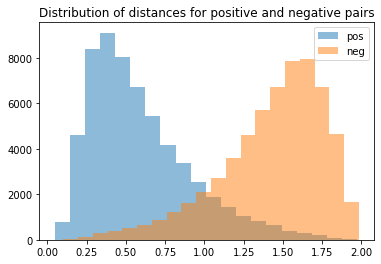

Validation: At-least-1-pos@1 0.840
Validation: At-least-1-pos@3 0.920
Epoch 4
[0/60000 (0%)]	Batch loss: 0.201567
[300/60000 (10%)]	Batch loss: 0.216432
[600/60000 (21%)]	Batch loss: 0.263901
[900/60000 (31%)]	Batch loss: 0.242602
[1200/60000 (42%)]	Batch loss: 0.301032
[1500/60000 (52%)]	Batch loss: 0.288321
[1800/60000 (63%)]	Batch loss: 0.194461
[2100/60000 (73%)]	Batch loss: 0.161948
[2400/60000 (84%)]	Batch loss: 0.275038
[2700/60000 (94%)]	Batch loss: 0.219436
Epoch average loss 0.004005


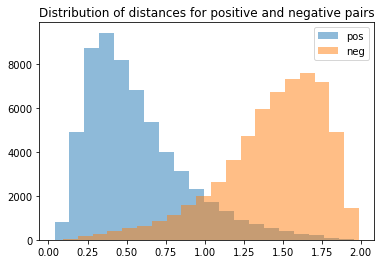

Validation: At-least-1-pos@1 0.860
Validation: At-least-1-pos@3 0.940
Epoch 5
[0/60000 (0%)]	Batch loss: 0.231537
[300/60000 (10%)]	Batch loss: 0.258222
[600/60000 (21%)]	Batch loss: 0.317703
[900/60000 (31%)]	Batch loss: 0.251563
[1200/60000 (42%)]	Batch loss: 0.302927
[1500/60000 (52%)]	Batch loss: 0.207373
[1800/60000 (63%)]	Batch loss: 0.229413
[2100/60000 (73%)]	Batch loss: 0.218314
[2400/60000 (84%)]	Batch loss: 0.303372
[2700/60000 (94%)]	Batch loss: 0.286932
Epoch average loss 0.003892


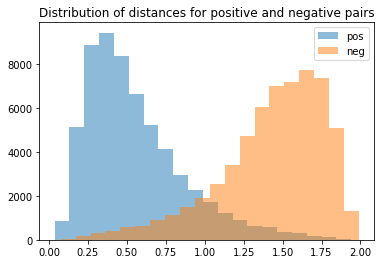

Validation: At-least-1-pos@1 0.820
Validation: At-least-1-pos@3 0.920
Epoch 6
[0/60000 (0%)]	Batch loss: 0.200422
[300/60000 (10%)]	Batch loss: 0.324240
[600/60000 (21%)]	Batch loss: 0.216167
[900/60000 (31%)]	Batch loss: 0.217422
[1200/60000 (42%)]	Batch loss: 0.246093
[1500/60000 (52%)]	Batch loss: 0.226414
[1800/60000 (63%)]	Batch loss: 0.220750
[2100/60000 (73%)]	Batch loss: 0.241893
[2400/60000 (84%)]	Batch loss: 0.270212
[2700/60000 (94%)]	Batch loss: 0.254191
Epoch average loss 0.003810


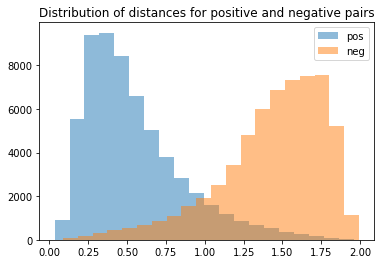

Validation: At-least-1-pos@1 0.830
Validation: At-least-1-pos@3 0.940
Epoch 7
[0/60000 (0%)]	Batch loss: 0.229307
[300/60000 (10%)]	Batch loss: 0.267210
[600/60000 (21%)]	Batch loss: 0.259436
[900/60000 (31%)]	Batch loss: 0.156593
[1200/60000 (42%)]	Batch loss: 0.227724
[1500/60000 (52%)]	Batch loss: 0.219273
[1800/60000 (63%)]	Batch loss: 0.248420
[2100/60000 (73%)]	Batch loss: 0.216799
[2400/60000 (84%)]	Batch loss: 0.220622
[2700/60000 (94%)]	Batch loss: 0.262596
Epoch average loss 0.003750


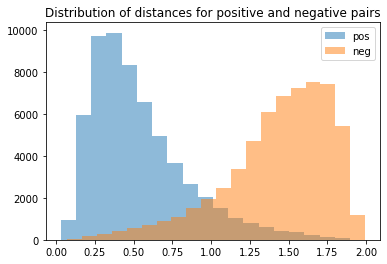

Validation: At-least-1-pos@1 0.830
Validation: At-least-1-pos@3 0.930
Epoch 8
[0/60000 (0%)]	Batch loss: 0.187467
[300/60000 (10%)]	Batch loss: 0.205823
[600/60000 (21%)]	Batch loss: 0.237408
[900/60000 (31%)]	Batch loss: 0.194024
[1200/60000 (42%)]	Batch loss: 0.251941
[1500/60000 (52%)]	Batch loss: 0.240221
[1800/60000 (63%)]	Batch loss: 0.232393
[2100/60000 (73%)]	Batch loss: 0.318745
[2400/60000 (84%)]	Batch loss: 0.180767
[2700/60000 (94%)]	Batch loss: 0.223990
Epoch average loss 0.003703


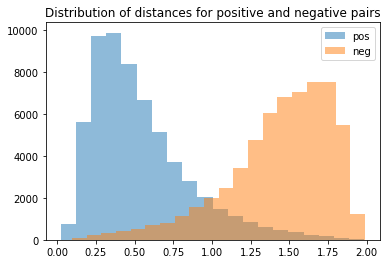

Validation: At-least-1-pos@1 0.850
Validation: At-least-1-pos@3 0.940
Epoch 9
[0/60000 (0%)]	Batch loss: 0.310021
[300/60000 (10%)]	Batch loss: 0.204945
[600/60000 (21%)]	Batch loss: 0.210453
[900/60000 (31%)]	Batch loss: 0.263353
[1200/60000 (42%)]	Batch loss: 0.239497
[1500/60000 (52%)]	Batch loss: 0.243049
[1800/60000 (63%)]	Batch loss: 0.264810
[2100/60000 (73%)]	Batch loss: 0.224736
[2400/60000 (84%)]	Batch loss: 0.216553
[2700/60000 (94%)]	Batch loss: 0.259707
Epoch average loss 0.003669


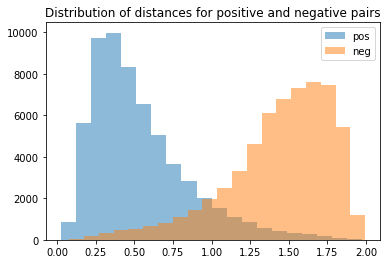

Validation: At-least-1-pos@1 0.860
Validation: At-least-1-pos@3 0.940
Epoch 10
[0/60000 (0%)]	Batch loss: 0.204900
[300/60000 (10%)]	Batch loss: 0.266092
[600/60000 (21%)]	Batch loss: 0.235068
[900/60000 (31%)]	Batch loss: 0.177758
[1200/60000 (42%)]	Batch loss: 0.246023
[1500/60000 (52%)]	Batch loss: 0.218505
[1800/60000 (63%)]	Batch loss: 0.231794
[2100/60000 (73%)]	Batch loss: 0.294010
[2400/60000 (84%)]	Batch loss: 0.170351
[2700/60000 (94%)]	Batch loss: 0.308630
Epoch average loss 0.003677


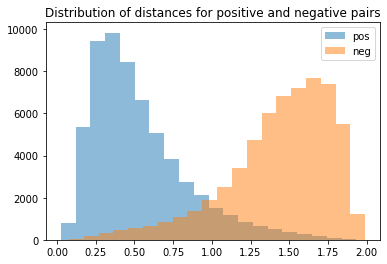

Validation: At-least-1-pos@1 0.860
Validation: At-least-1-pos@3 0.940


In [85]:
optimizer2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer2, 2, gamma=0.5)

print('Training with Contrastive loss and training triples')
# train with contrastive loss
contrastive_margin2 = 1
for epoch in range(1, 10 + 1):
    scheduler.step()
    print('Epoch {}'.format(epoch))
    train3(model, train_loader_triplets, optimizer2, contrastive_margin2)
    test(model, test_loader)